# MNIST digits CNN

This is a simple Deep Learning example loosely based on [this tutorial](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/).  
It will introduce you to CNNs and the basics of image data pipelines.

The objective of this model is to take in a simple black and white image of an handwritten digit and predict the digit it represents. The dataset we are using is quite famous in the AI world and is called [MNIST](http://yann.lecun.com/exdb/mnist/).

Since this is a CNN model it greatly benefits from using the GPU instead of the CPU. To sse this for yourself go to Runtime > Change runtime type in the top menu and choose either CPU or GPU, then compare the run time of the training. 


## Imports

In [8]:
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


plt.rcParams['figure.figsize'] = [10, 10]

## Global variables

In [9]:
# MNIST images are 28x28 pixels single-channel grayscale images.
IMAGE_SHAPE = (28, 28, 1)
# The classes are the digits to be predicted, from 0 to 9.
NUM_CLASSES = 10

EPOCHS = 10
BATCH_SIZE = 32

## Output functions

In [10]:
def plot_samples(X, y, one_hot_encoder, columns=3):
  """Show the images and corresponding labels."""
  N = y.shape[0]
  rows = int(np.ceil(N / columns))

  # y values are one-hot-encoded so we need to recover the label (the digit).
  labels = one_hot_encoder.inverse_transform(y).squeeze()

  for i, (sample_X, label) in enumerate(zip(X, labels)):
    plt.subplot(rows, columns, i+1)
    # .squeeze() removes the single channel which otherwise causes an error in some versions of matplotlib. 
    plt.imshow(sample_X.squeeze(), cmap=plt.get_cmap('gray'))
    plt.xlabel(f"Label: {label}")
  plt.tight_layout()
  plt.show()


def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", xlabel="", ylabel="", **kwargs):
  """
  Create a heatmap from a numpy array and two lists of labels.

  Parameters
  ----------
  data
      A 2D numpy array of shape (N, M).
  row_labels
      A list or array of length N with the labels for the rows.
  col_labels
      A list or array of length M with the labels for the columns.
  ax
      A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
      not provided, use current axes or create a new one.  Optional.
  cbar_kw
      A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
  cbarlabel
      The label for the colorbar.  Optional.
  **kwargs
      All other arguments are forwarded to `imshow`.
  """

  if not ax:
    ax = plt.gca()

  # Plot the heatmap
  im = ax.imshow(data, **kwargs)

  # Create colorbar
  cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
  cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

  # We want to show all ticks...
  ax.set_xticks(np.arange(data.shape[1]))
  ax.set_yticks(np.arange(data.shape[0]))
  # ... and label them with the respective list entries.
  ax.set_xticklabels(col_labels)
  ax.set_yticklabels(row_labels)

  # Let the horizontal axes labeling appear on top.
  ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

  # Turn spines off and create white grid.
  # ax.spines[:].set_visible(False)

  ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
  ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
  ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
  ax.tick_params(which="minor", bottom=False, left=False)

  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}", textcolors=("white", "black"), threshold=None, **textkw):
  """
  A function to annotate a heatmap.

  Parameters
  ----------
  im
      The AxesImage to be labeled.
  data
      Data used to annotate.  If None, the image's data is used.  Optional.
  valfmt
      The format of the annotations inside the heatmap.  This should either
      use the string format method, e.g. "$ {x:.2f}", or be a
      `matplotlib.ticker.Formatter`.  Optional.
  textcolors
      A pair of colors.  The first is used for values below a threshold,
      the second for those above.  Optional.
  threshold
      Value in data units according to which the colors from textcolors are
      applied.  If None (the default) uses the middle of the colormap as
      separation.  Optional.
  **kwargs
      All other arguments are forwarded to each call to `text` used to create
      the text labels.
  """

  if not isinstance(data, (list, np.ndarray)):
    data = im.get_array()

  # Normalize the threshold to the images color range.
  if threshold is not None:
    threshold = im.norm(threshold)
  else:
    threshold = im.norm(data.max())/2.

  # Set default alignment to center, but allow it to be
  # overwritten by textkw.
  kw = dict(horizontalalignment="center", verticalalignment="center")
  kw.update(textkw)

  # Get the formatter in case a string is supplied
  if isinstance(valfmt, str):
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

  # Loop over the data and create a `Text` for each "pixel".
  # Change the text's color depending on the data.
  texts = []
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
      text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
      texts.append(text)

  return texts


def plot_confusion_matrix(data, row_labels, col_labels, valfmt):
  fig, ax = plt.subplots()
  im, cbar = heatmap(data, row_labels, col_labels, xlabel="Predicted label", ylabel="True label")
  annotate_heatmap(im, valfmt=valfmt)
  plt.show()


def plot_history(history, metrics, restore_weights=True, yscale='linear', save_folder=None):
  """Plot the history af all specified metrics, comparing training and testing metrics."""

  if restore_weights and 'val_loss' in history.history.keys():
    # Find the epoch with the best result (which the model was restored to).
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"Restored weights to epoch: {best_epoch}")
  else:
    best_epoch = None

  # Plot the history of each metric.
  for metric in metrics:
    plt.figure()
    plt.title(metric)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.yscale(yscale)

    # Trained metric.
    plt.plot(history.history[metric])
    print(f"{metric}: {history.history[metric][best_epoch or len(history.history[metric]) - 1]}")

    val_metric = 'val_' + metric
    if val_metric in history.history.keys():
      # Same metric evaluated on the test set.
      plt.plot(history.history[val_metric])
      print(f"{val_metric}: {history.history[val_metric][best_epoch or len(history.history[metric]) - 1]}")

      # Highlight the epoch the weights were restored to.
      if restore_weights:
        plt.plot(best_epoch, history.history[val_metric][best_epoch], 'ro')

    plt.legend(['train', 'validation'], loc='best')

    if save_folder:
      plt.savefig(f'{save_folder}/{metric}')
    plt.show()

## Download the dataset

First of all we need to download the dataset. The MNIST dataset is actually one of the datasets which is included in Keras (read more about such datasets [here](https://keras.io/api/datasets/)), but we won't use that: we will actually download the PNG images of the MNIST dataset, to practice image loading and pipelines.

In [11]:
MNIST_DATA_URL = "https://github.com/imanlab/iml_dl_tutorial/raw/master/examples/mnist-digits-cnn/data/mnist-data-png.tar.xz"
DATA_DIR = "/content/data"
MNIST_DATA_PATH = os.path.join(DATA_DIR, "mnist-data-png.tar.xz")

!mkdir -p $DATA_DIR
# Download the file if it does not already exist.
if not os.path.exists(MNIST_DATA_PATH):
  !wget $MNIST_DATA_URL -O $MNIST_DATA_PATH

# Remove old data.
!rm -rf $DATA_DIR/testing $DATA_DIR/training
# Extract data.
!tar xf $MNIST_DATA_PATH --directory $DATA_DIR

## Load the data

In [12]:
def load_data(image_dir, one_hot_encoder=None):
  """Load the MNIST-digit images and labels from a given path."""

  image_names = os.listdir(image_dir)
  N = len(image_names)

  # List of images.
  X = np.empty((N, *IMAGE_SHAPE))
  # List of labels.
  y = np.empty((N, 1), dtype=str)

  """
  Regex to extract the label from the filename.

  Filenames are of the form UniqueId_Label.png where UniqueId is just a unique number identifying an image
  and Label is the digit that is represented in the image.
  """
  label_regex = re.compile(r"\d+_(\d)")

  for i, image_name in enumerate(image_names):
    # Load the image.
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)
    # Get the label.
    label = label_regex.match(image_name)[1]

    # Convert from image file to array.
    image_array = np.asarray(image)
    image_array = image_array.astype('float32')
    # Normalize all values to [0; 1)
    image_array = image_array / 255

    # Add sample to the list.
    X[i, ...] = np.expand_dims(image_array, axis=-1)
    y[i, 0] = label

  """
  The encoder performs what is called "one-hot encoding".

  It's a standard way to represent categorical data in Machine Learning. If our data can be one of N classes
  then we will represent the n-th label as a vector of length N with all 0 values except for the n-th which will be 1.
  This is doen because the model can only predict numerical values and labels are not (strictly) numerical.

  Example
  If the classes are ["cat", "dog", "table"] then N = 3
  "cat" => [1, 0, 0]
  "dog" => [0, 1, 0]
  "table" => [0, 0, 1]

  You can read more about it here:
  https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
  https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
  """
  if one_hot_encoder is None:
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoder.fit(y)
  
  y = one_hot_encoder.transform(y)
  
  # The encoder obect must be returned as it will be used to decode the predictions at the end.
  return X, y, one_hot_encoder


def load_dataset(data_dir):
  """Load both training and testing data."""

  train_dir = os.path.join(data_dir, "training")
  test_dir = os.path.join(data_dir, "testing")

  X_train, y_train, one_hot_encoder = load_data(train_dir)
  X_test, y_test, _ = load_data(test_dir, one_hot_encoder)

  return (X_train, y_train), (X_test, y_test), one_hot_encoder

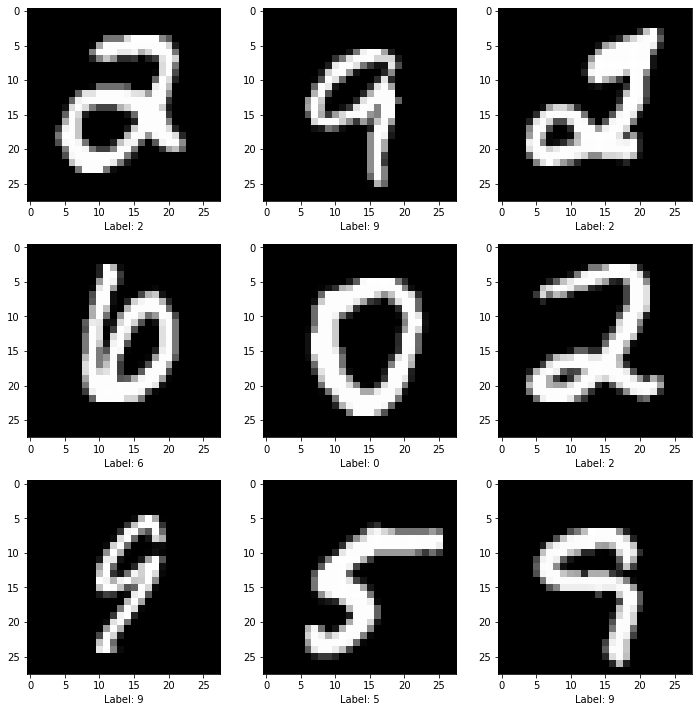

In [13]:
# Load data from the directory where images are stored.
(X_train, y_train), (X_test, y_test), one_hot_encoder = load_dataset(data_dir="data")

# Show a subset of the samples.
plot_samples(X_train[0:9], y_train[0:9], one_hot_encoder, columns=3)

## Model

In [14]:
def get_model():
  """Create the model."""

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=IMAGE_SHAPE))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  """
  A softmax activation is typical of the output layer for a classifier network.

  Softmax ensures that the N outputs of the layer sum to a total of 1.
  With regard to classification each weight can then be interpreted as a "confidence"
  that the sample can be classified as the label corresponding to that output.
  You can read more about softmax here: https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78
  """
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  """
  The learning rate and the momentum of the SGD optimizer are hyperparameters of the model:
  you can try running multiple training cycles with different values and see how they affect the results.
  """ 
  opt = SGD(learning_rate=0.01, momentum=0.9)
  """
  The categorical crossentropy loss function is used in classification problems.
  You can read more about it here: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

  Accuracy is a metric defined as (# of correct predictions / # of total predictions).
  You can read more about it here: https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
  """
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

Epoch 1/10
1875/1875 [==============================] - 43s 8ms/step - loss: 0.1163 - accuracy: 0.9636
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0423 - accuracy: 0.9864
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0270 - accuracy: 0.9915
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0204 - accuracy: 0.9935
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0147 - accuracy: 0.9955
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0115 - accuracy: 0.9964
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0083 - accuracy: 0.9973
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0068 - accuracy: 0.9977
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0063 - accuracy: 0.9978
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - l

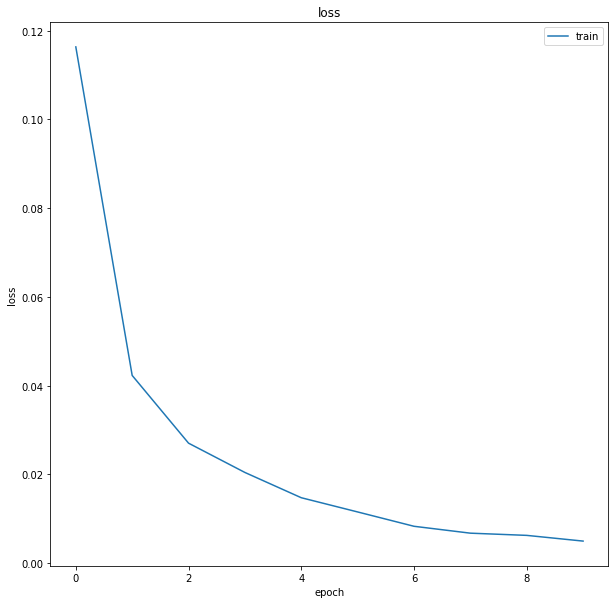

accuracy: 0.9985166788101196


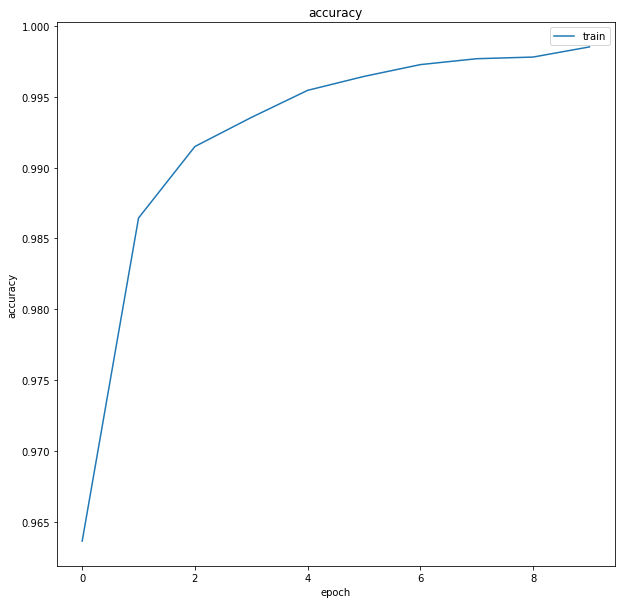

In [15]:
model = get_model()
# Train the model.
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
plot_history(history, ['loss', 'accuracy'], restore_weights=False)

# Save model for future use.
model.save('models/model.h5')

# For example the model could be loaded like this on antother machine.
# model = tensorflow.keras.models.load_model('models/model.h5')

## Evaluation

In [16]:
# Predictions.
y_test_preds = model(X_test)
y_test_labels = one_hot_encoder.inverse_transform(y_test).squeeze()
y_test_pred_labels = one_hot_encoder.inverse_transform(y_test_preds).squeeze()

categories = one_hot_encoder.categories_[0].tolist()

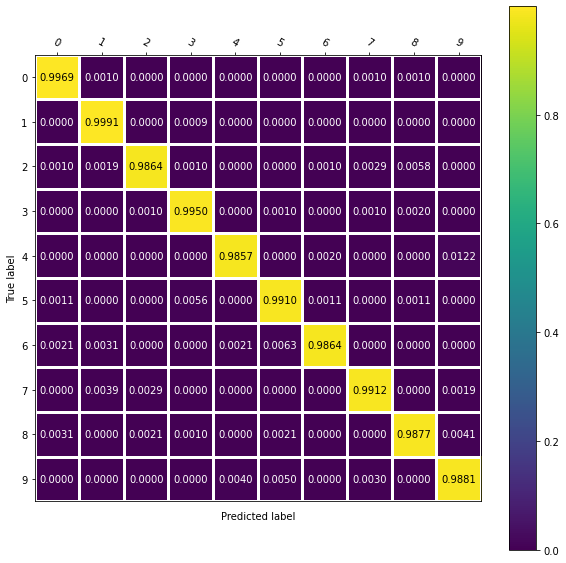

In [17]:
"""
Plot confusion matrix.

The confusion matrix represents the results of all predictions from our model and is useful to determine
both its general performance and specific problems (e.g. one digit could tend to be confused with another one).
"""
confusion_matrix = np.zeros((10, 10))
for label, pred_label in zip(y_test_labels, y_test_pred_labels):
    idx_true = categories.index(label)
    idx_pred = categories.index(pred_label)
    confusion_matrix[idx_true, idx_pred] += 1
confusion_matrix_norm = confusion_matrix / np.expand_dims(np.sum(confusion_matrix, axis=1), axis=-1)
plot_confusion_matrix(confusion_matrix_norm, categories, categories, "{x:.4f}")

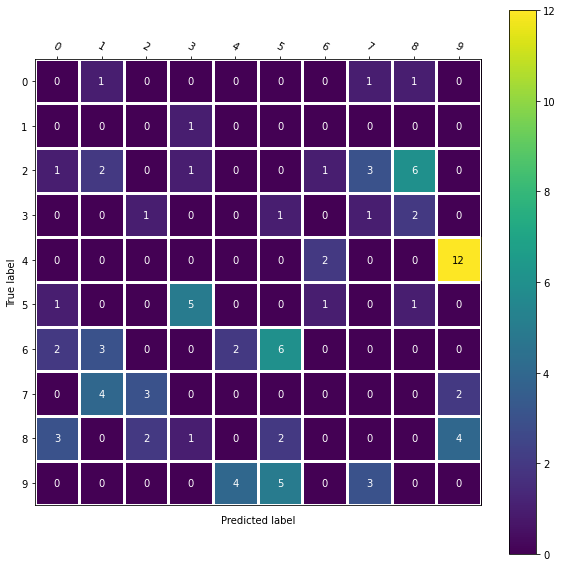

In [18]:
"""
Plot the confusion matrix with wrong predictions only.

This is obtained by removing the diagonal. This is not a canonical form of the confusion matrix, but it makes
it easier to see the colors and where wrong predictions accumulate if the network is really accurate.

An alternative would be to use logarithmic color scaling.
"""
confusion_matrix_errors = confusion_matrix - np.diag(np.diag(confusion_matrix))
plot_confusion_matrix(confusion_matrix_errors, categories, categories, "{x:.0f}")

In [19]:
# Calculate prediction accuracy.
pred_correct = np.sum([confusion_matrix[i, i] for i in range(10)])
pred_total = y_test_preds.shape[0]
acc = pred_correct / pred_total
print(f"Model accuracy: {acc:.4f}")

Model accuracy: 0.9909
